# MBA em Ciência de Dados
### Universidade de São Paulo, São Carlos, Brasil

**Disciplina:** Gestão

**Professor Reponsável:** Prof. Dr. Francisco Louzada Neto


**Autor:** Edesio Alcobaça
📧 edesio@usp.br
🌐 [linkedin](https://www.linkedin.com/in/ealcobaca/)
🔗 [site](https://ealcobaca.github.io/)

# **Being fast with Transfer Learning**: Um caso de estudo de classificação do uso correto de máscaras de proteção



## **Agenda**

Na aula de hoje iremos abordar os seguintes tópicos do desenvolvimento deste projeto:

1. Retomando Conceitos

2. Entendimento do Negócio (Definição do Problema);

3. Entendimento dos Dados;

4. Preparação dos Dados;

5. Treinamento (Modelagem);

6. Avaliação;

7. Deployment.

8. Além do Deployment: O que vem depois e não te contaram


## **Retomando Conceitos**

### CRISP-DS
<br>

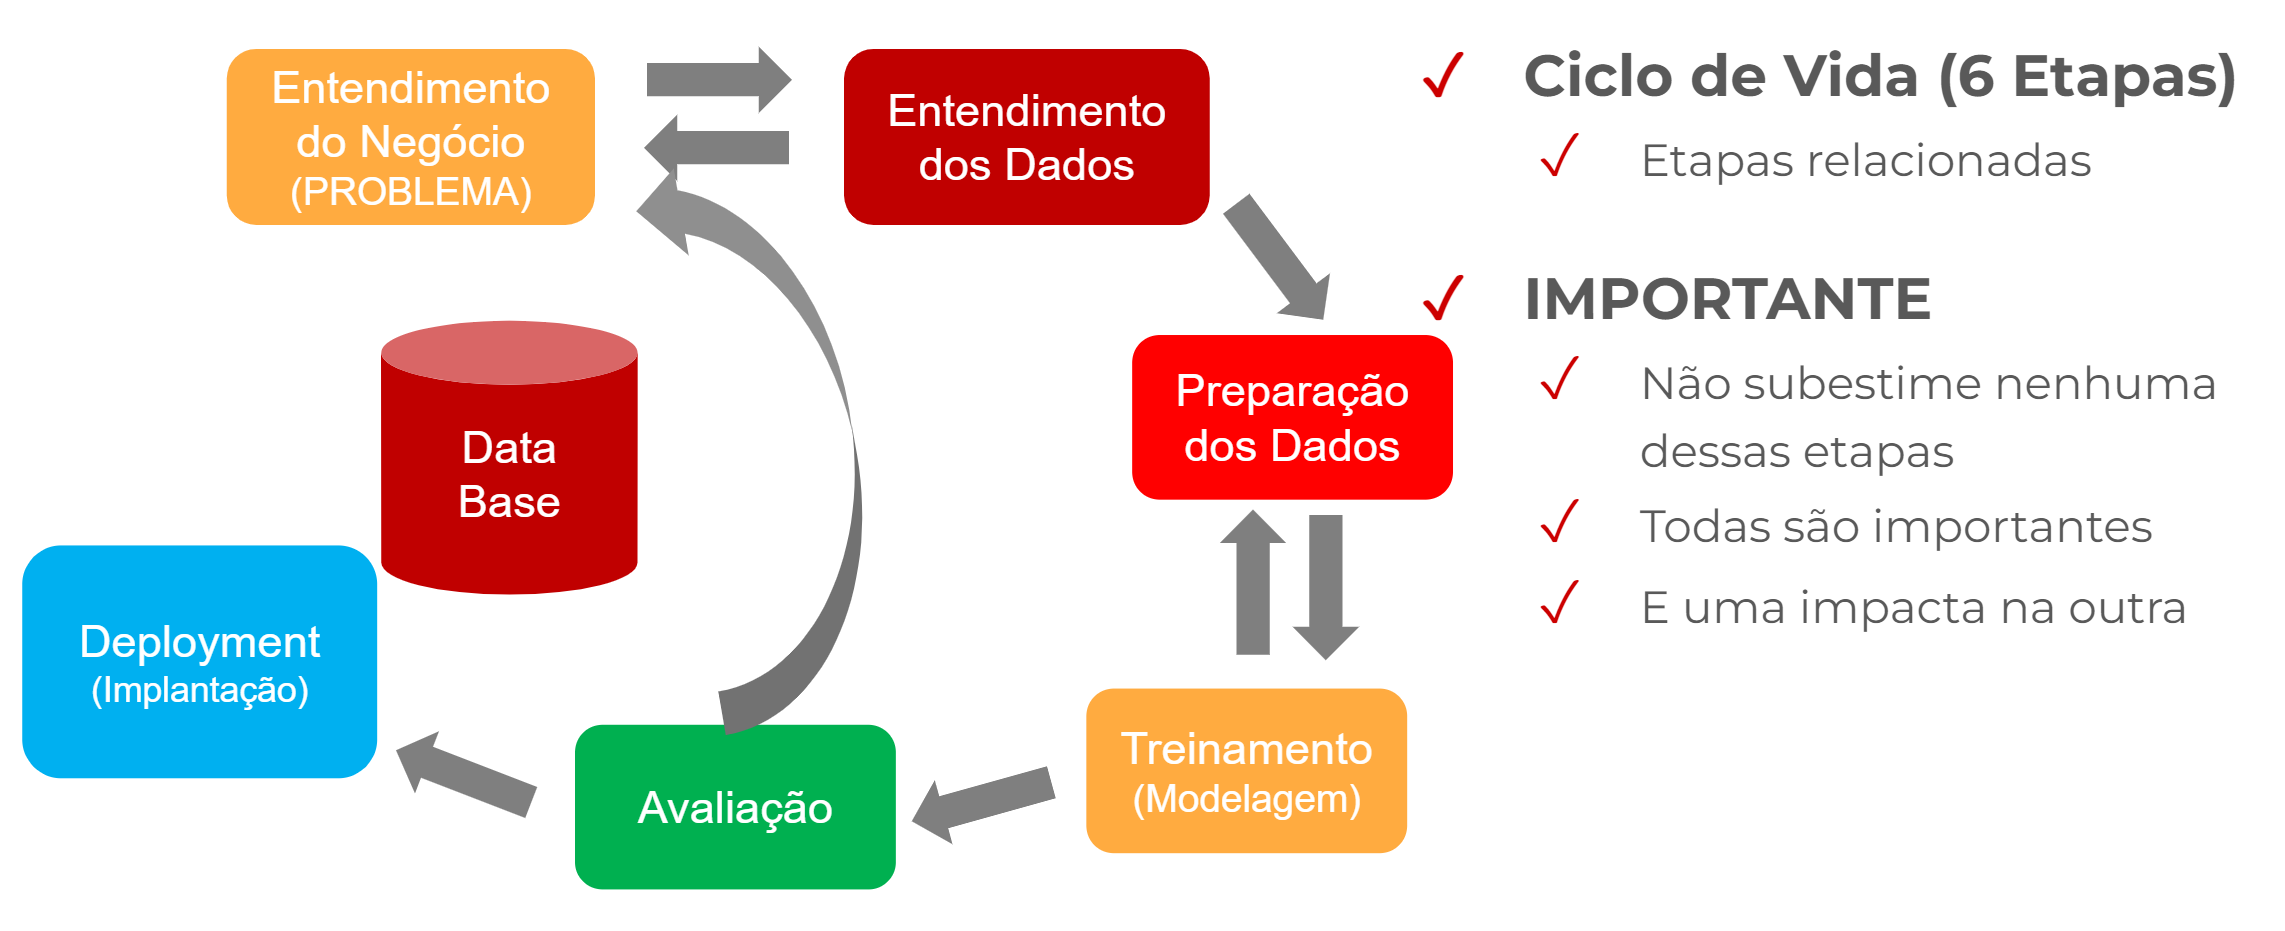

## **2. Entendimento do Negócio (Definição do Problema)**

### Problema

As máscaras desempenham um papel crucial na proteção da saúde dos indivíduos contra doenças respiratórias, sendo uma das poucas precauções disponíveis para a COVID-19 na ausência de imunização.

Uma empresa deseja estimar a quantidade de pessoas usando incorretamente (ou não usando) máscaras de proteção em ambientes fechados com objetivo de criar politicas de concientização.

### Riscos

* Poucos dados rotulados
* Sem recurso para rotular novos dados
* Não é possível abordagens clássicas como CNN

### Objetivo

Criar modelo para classificar:
* pessoa usando máscara corretamente
* pessoa usando máscara incorretamente
* pessoa não usando máscara
* outra imagem qualquer

Transferência de Aprendizado:
* Gerar feature embeddings de modelos pré-treinados
* Fine tuning

## **3. Entendimento dos Dados**

### Entendendo os Dados

Os dados são imagens (JPG) de pessoas usando máscara após recorte de imagens feito por um sistema de segmentação.

O arquivo 'mask_datase.zip' contém a seguinte estrutura:

    root
        fully_coverd
        not_covered
        not_face
        partially_covered



* **fully_coverd:** pessoa usando máscara corretamente
* **partially_covered:** pessoa usando máscara incorretamente
* **not_covered:** pessoa sem máscara
* **not_face:** outra imagem qualquer que não é face





In [ ]:
!unzip -qq mask_dataset.zip -d mask_dataset
!unzip -qq image_output.zip -d image_output

### Análise Exploratória de Dados

Leitura das imagens direto do diretorio

In [ ]:
import os
import numpy as np
from PIL import Image
import warnings

warnings.filterwarnings("ignore")

def read_image_from_dir(
    directory,
    image_size,
    color_mode="RGB",
):

  classes = {k: v for v, k in enumerate(os.listdir(directory))}

  X = []
  y = []

  for k, v in classes.items():

    class_dir = os.path.join(directory, k)
    images_dirs = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
          if os.path.isfile(os.path.join(class_dir, f))
    ]

    for i in images_dirs:
      img = Image.open(i)
      img = img.convert('L')
      img = img.convert(color_mode)
      img = img.resize(image_size)

      X.append(np.asarray(img))
      y.append(v)

  return np.array(X), np.array(y), classes

In [ ]:
directory = "mask_dataset/"
image_size = (224, 224)

X, y, classes = read_image_from_dir(directory, image_size)

In [ ]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (6621, 224, 224, 3)
y shape:  (6621,)


Aqui vamos criar um função para tirar uma amostra balanceada das imagens para modelarmos o problema.


In [ ]:
def balanced_sample(X, y, sample, n_classes, seed):
  np.random.seed(seed)
  sample_idx = []
  for i in range(n_classes):
    sample_vector_i = np.where(y == i)[0]
    sample_idx_i = np.random.choice(sample_vector_i, size=sample)
    sample_idx.append(sample_idx_i)

  sample_idx = np.asarray(sample_idx).flatten()
  X, y = X[sample_idx], y[sample_idx]

  return X, y

In [ ]:
sample = 300
n_classes = 4
seed = 42
X, y = balanced_sample(X, y, sample, n_classes, 42)

In [ ]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (1200, 224, 224, 3)
y shape:  (1200,)


In [ ]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3]), array([300, 300, 300, 300]))

A função a baixo foi criada para imprimir as imagens RGB

In [ ]:
def show_array_image(x, c):

  import math
  from matplotlib import pyplot as plt

  plt.figure()

  size = len(x)
  size = 2 if size < 4 else math.ceil(math.sqrt(size))
  f, ax = plt.subplots(size, size)

  for img, axi, ci in zip(x, ax.flatten(), c):
    axi.imshow(img, interpolation='none')
    axi.title.set_text(ci)

  for axi in ax.flatten():
    axi.axis("off")

  plt.show()

Vamos imprimir uma amostra de 9 imagens do conjunto de dados que temos:

<Figure size 640x480 with 0 Axes>

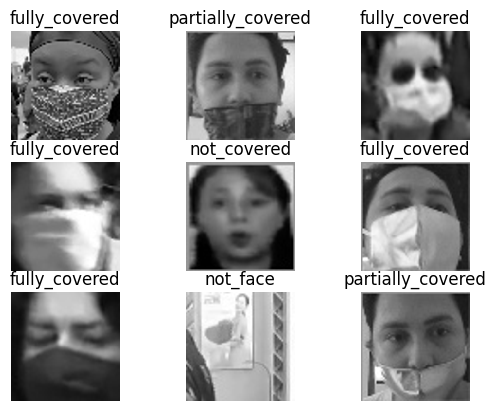

In [ ]:
classes_ = {v: k for k, v in classes.items()}
y_ = np.asarray([classes_[i] for i in y])

np.random.seed(10)
rd = np.random.randint(low=0, high=len(y_), size=9)

show_array_image(X[rd], y_[rd])

In [ ]:
def print_image_by_class(X, y, class_type):
  y_ = np.asarray([classes_[i] for i in y])
  X_ = X[y_ == class_type]
  y_ = y_[y_ == class_type]

  np.random.seed(10)
  rd = np.random.randint(low=0, high=len(y_), size=9)

  show_array_image(X_[rd], y_[rd])

Vamos imprimir uma amostra de 9 imagens apenas da classe 'not_face':

<Figure size 640x480 with 0 Axes>

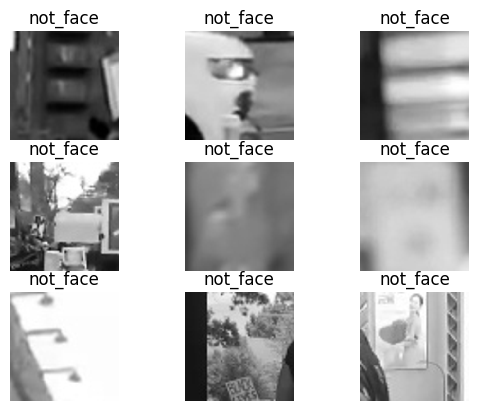

In [ ]:
print_image_by_class(X, y, "not_face")

Vamos imprimir uma amostra de 9 imagens apenas da classe 'not_covered':

<Figure size 640x480 with 0 Axes>

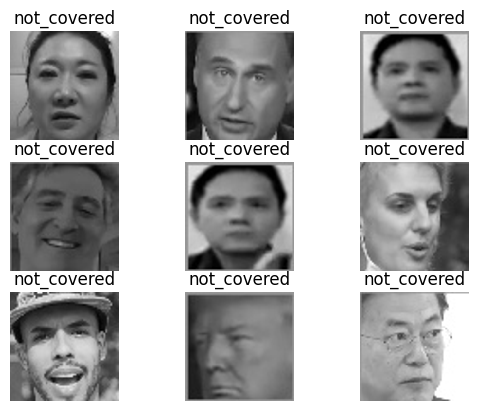

In [ ]:
print_image_by_class(X, y, "not_covered")

Vamos imprimir uma amostra de 9 imagens apenas da classe 'partially_covered':

<Figure size 640x480 with 0 Axes>

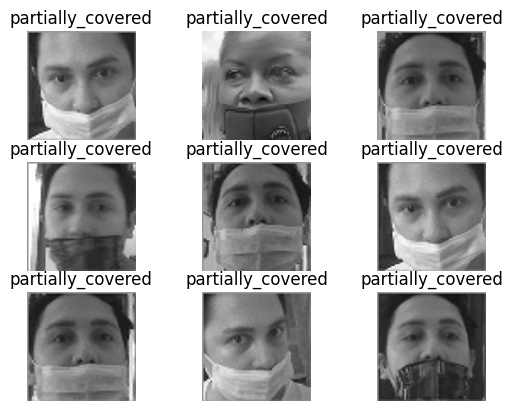

In [ ]:
print_image_by_class(X, y, "partially_covered")

Vamos imprimir uma amostra de 9 imagens apenas da classe 'fully_covered':

<Figure size 640x480 with 0 Axes>

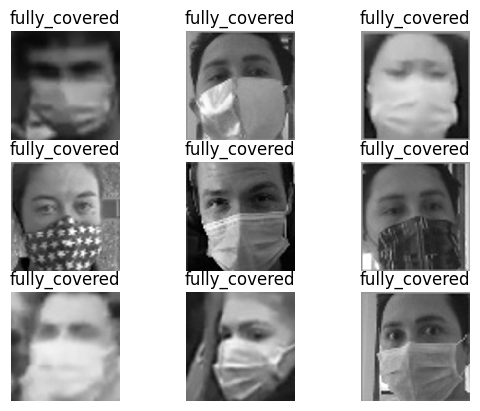

In [ ]:
print_image_by_class(X, y, "fully_covered")

## **4. Preparação dos Dados**


### Data Partition

In [ ]:
from sklearn.model_selection import train_test_split

seed = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (960, 224, 224, 3)
y_train shape:  (960,)
X_test shape:  (240, 224, 224, 3)
y_test shape:  (240,)


### Image Preprocessing

In [ ]:
X_train_flatten = np.asarray([i.flatten() for i in X_train])
X_test_flatten = np.asarray([i.flatten() for i in X_test])

In [ ]:
print("X_train_flatten shape: ", X_train_flatten.shape)
print("X_test_flatten shape: ", X_test_flatten.shape)

X_train_flatten shape:  (960, 150528)
X_test_flatten shape:  (240, 150528)


### Feature Embedding

#### VGG architecture

[Very Deep Convolutional Networks for Large-Scale Image Recognition Article](https://arxiv.org/abs/1409.1556)

![VGG19](https://www.researchgate.net/publication/359771670/figure/fig5/AS:11431281079634597@1660789329088/VGG-19-Architecture-39-VGG-19-has-16-convolution-layers-grouped-into-5-blocks-After.png)

Leitura do modelo usando a biblioteca Keras

In [ ]:
from tensorflow.keras.applications import vgg19

base_model = vgg19.VGG19(weights='imagenet', include_top=True)
base_model.summary()

574710816/574710816 [==============================] - 6s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Podemos imprimir a arquitetura usando 'plot_model'

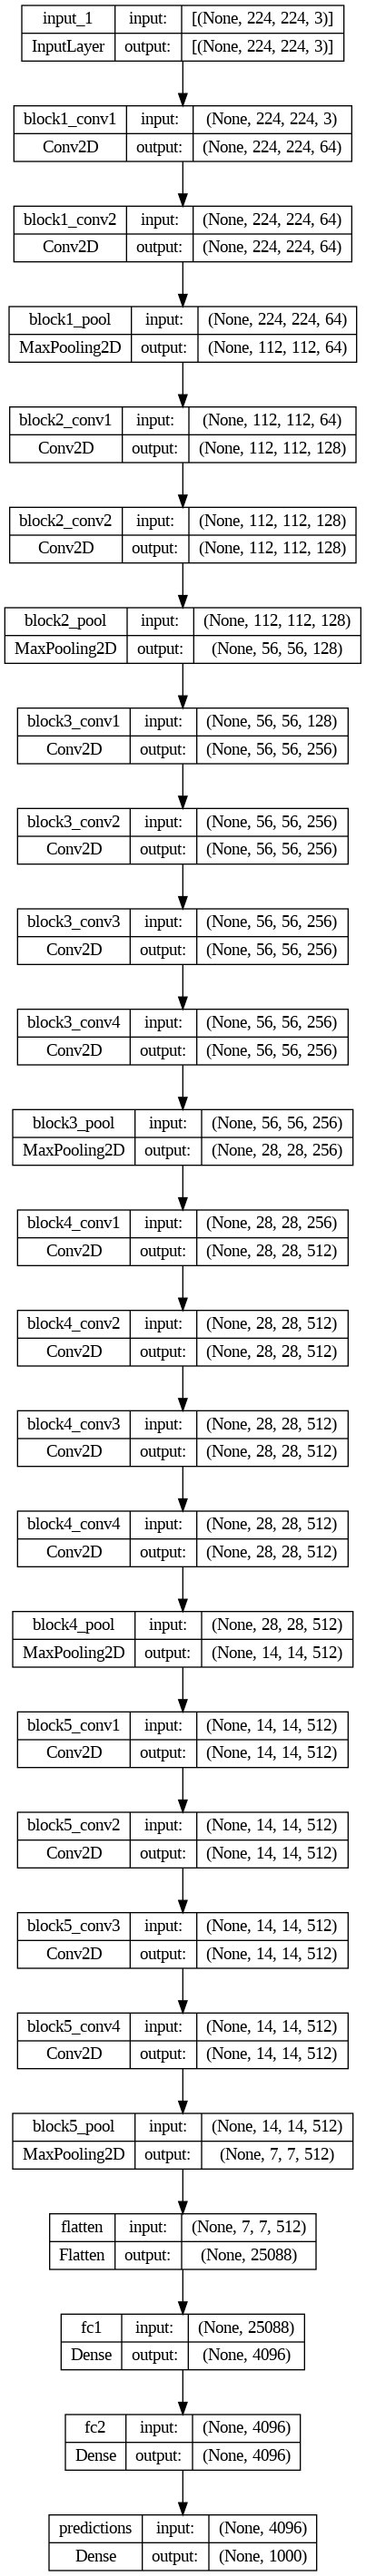

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image


plot_model(base_model, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

Criamos uma função para processar a entrada adequadamente para o VGG19

In [ ]:
from tensorflow.keras.applications import vgg19

datasets = [X_train, X_test]

def process_input(f, datasets, expand=False):
  result = []
  for d in datasets:
    if expand:
      d = [np.expand_dims(i, axis=0) for i in d]
    d = np.asarray([f(i) for i in d])
    result.append(d)
  return result

In [ ]:
X_train_prep, X_test_prep = process_input(vgg19.preprocess_input, datasets)

print("X_train_prep shape: ", X_train_prep.shape)
print("X_test_prep shape: ", X_test_prep.shape)

X_train_prep shape:  (960, 224, 224, 3)
X_test_prep shape:  (240, 224, 224, 3)


Criamos o feature embedding usando a ultima camada de convolução da VGG19

In [ ]:
from tensorflow.keras import Model

feature_extractor = Model(
    inputs=base_model.input,
    outputs=base_model.get_layer('flatten').output
)

Aqui realizamos a extração de feature embeddings

In [ ]:
X_train_embeddings = preds = feature_extractor.predict(X_train_prep)
X_test_embeddings = feature_extractor.predict(X_test_prep)

print("X_train_embeddings shape: ", X_train_embeddings.shape)
print("X_test_embeddings shape: ", X_test_embeddings.shape)

8/8 [==============================] - 3s 398ms/step
X_train_embeddings shape:  (960, 25088)
X_test_embeddings shape:  (240, 25088)


## **5. Treinamento (Modelagem)**

### Baseline: random

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

labels_name = [classes_[i] for i in range(len(classes_))]

pipe_dummy = Pipeline([
    ('dummy', DummyClassifier(strategy="most_frequent"))
])

clf_dummy = pipe_dummy.fit(X_train_flatten, y_train)
y_pred_clf_dummy = clf_dummy.predict(X_test_flatten)

report = classification_report(y_test, y_pred_clf_dummy, target_names=labels_name)
print(report)

                   precision    recall  f1-score   support

         not_face       0.00      0.00      0.00        62
partially_covered       0.00      0.00      0.00        60
      not_covered       0.00      0.00      0.00        60
    fully_covered       0.24      1.00      0.39        58

         accuracy                           0.24       240
        macro avg       0.06      0.25      0.10       240
     weighted avg       0.06      0.24      0.09       240



In [ ]:
from sklearn.model_selection import cross_validate
import seaborn as sns

cv_results_pipe_dummy = cross_validate(pipe_dummy, X_train_flatten, y_train, cv=10)
cv_results_pipe_dummy

{'fit_time': array([0.04055262, 0.03900886, 0.03857446, 0.04010749, 0.03954196,
        0.03915644, 0.04371405, 0.03987122, 0.0397346 , 0.03963447]),
 'score_time': array([0.00058126, 0.00049138, 0.00054669, 0.00070286, 0.00065804,
        0.00058579, 0.00052881, 0.00049686, 0.00056553, 0.00050664]),
 'test_score': array([0.25      , 0.25      , 0.25      , 0.25      , 0.25      ,
        0.25      , 0.25      , 0.25      , 0.26041667, 0.26041667])}

In [ ]:
def print_data(data):
  for k, v in data.items():
    print(f"{k}: {round(np.mean(v), 4)} +- {round(np.std(v), 4)}")

print_data(cv_results_pipe_dummy)

fit_time: 0.04 +- 0.0014
score_time: 0.0006 +- 0.0001
test_score: 0.2521 +- 0.0042


### Baseline: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=.95)),
    ('lr', LogisticRegression(random_state=42))
])

clf_lr = pipe_lr.fit(X_train_flatten, y_train)
y_pred_clf_lr = clf_lr.predict(X_test_flatten)

report = classification_report(y_test, y_pred_clf_lr, target_names=labels_name)
print(report)

                   precision    recall  f1-score   support

         not_face       0.80      0.79      0.80        62
partially_covered       0.85      0.95      0.90        60
      not_covered       0.85      0.75      0.80        60
    fully_covered       0.78      0.79      0.79        58

         accuracy                           0.82       240
        macro avg       0.82      0.82      0.82       240
     weighted avg       0.82      0.82      0.82       240



In [ ]:
cv_results_pipe_lr = cross_validate(pipe_lr, X_train_flatten, y_train, cv=10)
cv_results_pipe_lr

{'fit_time': array([ 88.32810211,  92.38231134,  99.58220863,  94.45052075,
         82.42434764,  92.42550492, 106.23379302,  77.0646596 ,
         74.61893106,  71.90727711]),
 'score_time': array([0.31573153, 0.51025105, 0.62126064, 0.28687382, 0.48148561,
        0.67404127, 1.03327179, 0.29723072, 0.2883513 , 0.50737643]),
 'test_score': array([0.73958333, 0.8125    , 0.82291667, 0.75      , 0.8125    ,
        0.79166667, 0.85416667, 0.80208333, 0.80208333, 0.80208333])}

In [ ]:
print_data(cv_results_pipe_lr)

fit_time: 87.9418 +- 10.6573
score_time: 0.5016 +- 0.2225
test_score: 0.799 +- 0.0316


### Embedding + Logistic Regression

In [ ]:
pipe_embeddings_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=.95)),
    ('lr', LogisticRegression(random_state=42))
])

clf_embeddings_lr = pipe_embeddings_lr.fit(X_train_embeddings, y_train)
y_pred_clf_embeddings_lr = clf_embeddings_lr.predict(X_test_embeddings)

report = classification_report(y_test, y_pred_clf_embeddings_lr, target_names=labels_name)
print(report)

                   precision    recall  f1-score   support

         not_face       0.97      0.97      0.97        62
partially_covered       1.00      1.00      1.00        60
      not_covered       0.98      0.98      0.98        60
    fully_covered       0.95      0.95      0.95        58

         accuracy                           0.97       240
        macro avg       0.97      0.97      0.97       240
     weighted avg       0.97      0.97      0.97       240



In [ ]:
cv_results_pipe_embeddings_lr = cross_validate(pipe_embeddings_lr, X_train_embeddings, y_train, cv=10)
cv_results_pipe_embeddings_lr

{'fit_time': array([7.26284099, 6.35529709, 5.54916453, 7.84533954, 6.3472898 ,
        7.32177019, 5.65549874, 8.35601544, 6.15939236, 7.49007583]),
 'score_time': array([0.19223642, 0.07968616, 0.13527203, 0.07333875, 0.14810681,
        0.07791758, 0.07755876, 0.08037615, 0.0970552 , 0.08469296]),
 'test_score': array([0.97916667, 1.        , 0.97916667, 0.96875   , 0.97916667,
        0.95833333, 0.98958333, 0.94791667, 0.95833333, 0.9375    ])}

In [ ]:
print_data(cv_results_pipe_embeddings_lr)

fit_time: 6.8343 +- 0.9029
score_time: 0.1046 +- 0.0382
test_score: 0.9698 +- 0.0183


### Embedding + SVM

In [ ]:
from sklearn.svm import SVC

pipe_embeddings_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=.95)),
    ('svc', SVC(random_state=42))
])

clf_embeddings_svc = pipe_embeddings_svc.fit(X_train_embeddings, y_train)
y_pred_clf_embeddings_svc = clf_embeddings_svc.predict(X_test_embeddings)

report = classification_report(y_test, y_pred_clf_embeddings_svc, target_names=labels_name)
print(report)

                   precision    recall  f1-score   support

         not_face       0.95      0.95      0.95        62
partially_covered       1.00      0.98      0.99        60
      not_covered       0.92      1.00      0.96        60
    fully_covered       0.94      0.88      0.91        58

         accuracy                           0.95       240
        macro avg       0.95      0.95      0.95       240
     weighted avg       0.95      0.95      0.95       240



In [ ]:
cv_results_pipe_embeddings_svc = cross_validate(pipe_embeddings_svc, X_train_embeddings, y_train, cv=10)
cv_results_pipe_embeddings_svc

{'fit_time': array([7.75909591, 6.59277129, 7.87684131, 6.82551956, 6.87046337,
        8.21354604, 7.84237123, 6.73851085, 7.32123661, 6.76649451]),
 'score_time': array([0.11502814, 0.21624041, 0.12901258, 0.19028091, 0.13304377,
        0.21170735, 0.11153054, 0.20862055, 0.11582923, 0.19402385]),
 'test_score': array([0.98958333, 0.98958333, 0.94791667, 0.95833333, 0.96875   ,
        0.9375    , 0.95833333, 0.97916667, 0.9375    , 0.95833333])}

In [ ]:
print_data(cv_results_pipe_embeddings_svc)

fit_time: 7.2807 +- 0.5638
score_time: 0.1625 +- 0.0427
test_score: 0.9625 +- 0.0182


### Fine Tuning

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def fine_tune_model_builder():
  base_model = vgg19.VGG19(weights='imagenet', include_top=True)

  # congelar camadas nao tunadas
  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.layers[-7].output
  x = Flatten()(x)
  x = Dense(16, activation='relu')(x)
  x = Dense(8, activation='relu')(x)
  x = Dense(4, activation='softmax')(x)

  return Model(inputs=base_model.input, outputs=x)

fine_tune_model = fine_tune_model_builder()
fine_tune_model.summary()

m = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

fine_tune_model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=m)

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

history=fine_tune_model.fit(X_train_prep, y_train_ohe, validation_split=0.10, epochs=10, verbose=1)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
n_perf = ["accuracy", "precision", "recall", "auc", "loss"]
n_perf_val = ["val_"+i for i in n_perf]

perf = [history.history[i] for i in n_perf]
perf_val = [history.history[i] for i in n_perf_val]

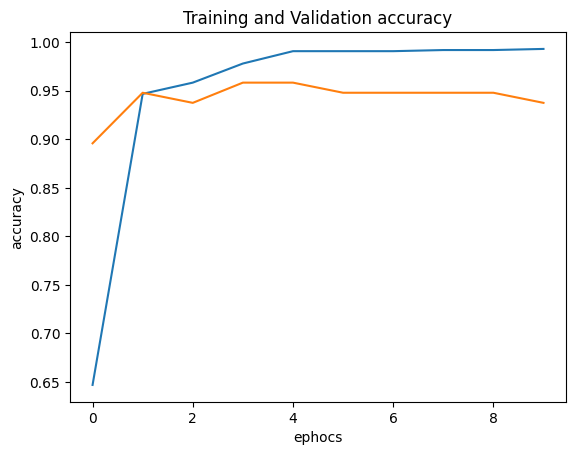

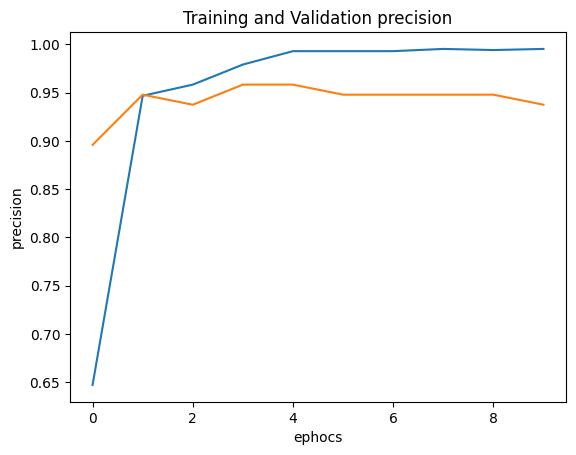

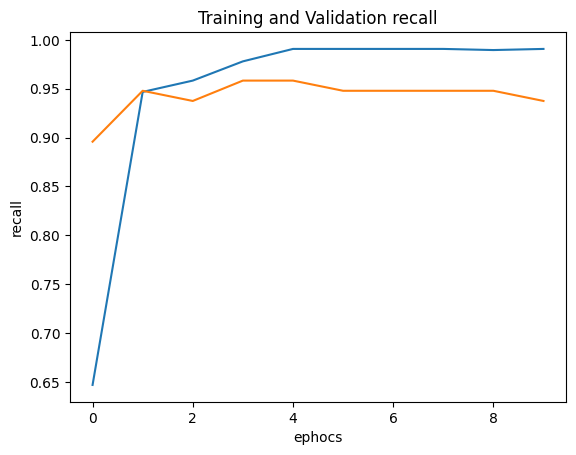

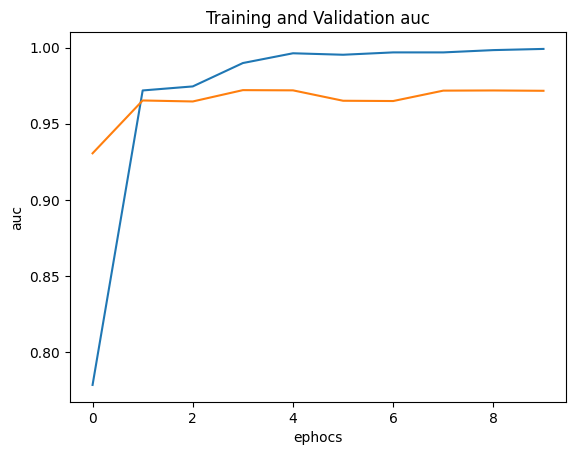

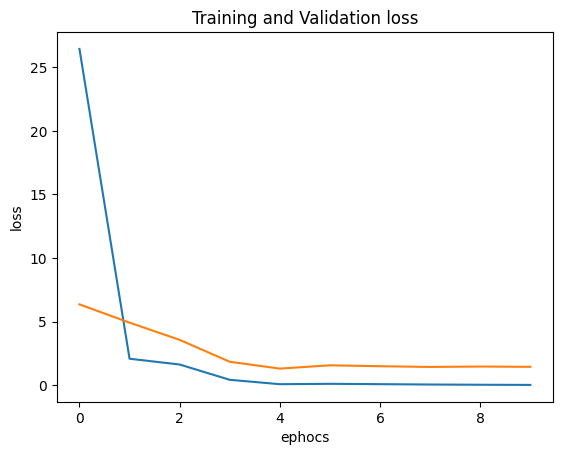

In [ ]:
import matplotlib.pyplot as plt

def plot_perf(measure, measure_val, measure_name):
  epochs_range = range(len(measure))
  plt.plot(epochs_range, measure, label=f'Training {measure_name}')
  plt.plot(epochs_range, measure_val, label=f'Validation {measure_name}')
  plt.title(f'Training and Validation {measure_name}')
  plt.xlabel("ephocs")
  plt.ylabel(measure_name)

  plt.show()

for n, i, j in zip(n_perf, perf, perf_val):
  plot_perf(i, j, n)


In [ ]:
y_pred_prob = fine_tune_model.predict(X_test_prep)
y_pred_fine_tune_model = y_pred_prob.argmax(axis=-1)
report = classification_report(y_test, y_pred_fine_tune_model, target_names=labels_name)
print(report)

8/8 [==============================] - 1s 152ms/step
                   precision    recall  f1-score   support

         not_face       0.97      1.00      0.98        62
partially_covered       0.97      0.97      0.97        60
      not_covered       1.00      0.97      0.98        60
    fully_covered       0.97      0.97      0.97        58

         accuracy                           0.97       240
        macro avg       0.98      0.97      0.97       240
     weighted avg       0.98      0.97      0.97       240



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import time


def cross_validate_keras(model, X, y, m, cv=10,):
  kf = KFold(n_splits=cv)
  result = {
      'fit_time': [],
      'score_time': [],
      'test_score': []
      }

  y_train_ohe = to_categorical(y)

  for train, test in kf.split(X, y):

      start_time_fit = time.time()
      fine_tune_model_i = model()
      fine_tune_model_i.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=m)
      history=fine_tune_model_i.fit(X[train], y_train_ohe[train], validation_split=0.10, epochs=10, verbose=1)
      end_time_fit = time.time()
      elapsed_time_fit = end_time_fit - start_time_fit

      start_time_test = time.time()
      acc_train_i = history.history["accuracy"]
      y_pred_prob_i = fine_tune_model.predict(X[test])
      y_pred_fine_tune_model_i = y_pred_prob_i.argmax(axis=-1)
      acc_test_i = accuracy_score(y[test], y_pred_fine_tune_model_i)
      end_time_test = time.time()
      elapsed_time_test = end_time_test - start_time_test

      result["fit_time"].append(elapsed_time_fit)
      result["score_time"].append(elapsed_time_test)
      result["test_score"].append(acc_test_i)

  return result

In [ ]:
cv_results_fine_tune = cross_validate_keras(fine_tune_model_builder, X_train_prep, y_train, m, cv=10)
cv_results_fine_tune

Epoch 1/10
25/25 [==============================] - 12s 451ms/step - loss: 33.5588 - accuracy: 0.6506 - precision: 0.6506 - recall: 0.6506 - auc: 0.7751 - val_loss: 4.6622 - val_accuracy: 0.8736 - val_precision: 0.8736 - val_recall: 0.8736 - val_auc: 0.9150
Epoch 2/10
25/25 [==============================] - 5s 186ms/step - loss: 1.6733 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9754 - val_loss: 5.4616 - val_accuracy: 0.8966 - val_precision: 0.8966 - val_recall: 0.8966 - val_auc: 0.9306
Epoch 3/10
25/25 [==============================] - 5s 190ms/step - loss: 0.3041 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9858 - auc: 0.9931 - val_loss: 2.7129 - val_accuracy: 0.9310 - val_precision: 0.9310 - val_recall: 0.9310 - val_auc: 0.9611
Epoch 4/10
25/25 [==============================] - 5s 190ms/step - loss: 0.1365 - accuracy: 0.9949 - precision: 0.9949 - recall: 0.9949 - auc: 0.9974 - val_loss: 2.2855 - val_accuracy: 0.9540 - val_precision: 0.9540 - val_recall:

{'fit_time': [86.33722972869873,
  52.1728892326355,
  51.63891625404358,
  87.07871675491333,
  86.48111939430237,
  86.41036653518677,
  87.82129311561584,
  88.94564461708069,
  89.35662603378296,
  94.17407417297363],
 'score_time': [0.7030880451202393,
  0.6460080146789551,
  0.7942295074462891,
  0.7892699241638184,
  0.7844083309173584,
  0.8291306495666504,
  0.6693422794342041,
  0.7893855571746826,
  0.8001210689544678,
  0.6587138175964355],
 'test_score': [0.96875,
  0.9895833333333334,
  0.9895833333333334,
  0.9895833333333334,
  0.96875,
  0.9895833333333334,
  0.9791666666666666,
  0.96875,
  0.9791666666666666,
  0.9166666666666666]}

In [ ]:
print_data(cv_results_fine_tune)

fit_time: 81.0417 +- 14.7338
score_time: 0.7464 +- 0.0654
test_score: 0.974 +- 0.021


## **6. Avaliação**


### Validation Performance


In [ ]:
import pandas as pd

size = 10
cv_results_pipe_dummy["models"] = ["dummy"] * size
cv_results_fine_tune["models"] = ["fine-tune"] * size
cv_results_pipe_lr["models"] = ["pca+lr"] * size
cv_results_pipe_embeddings_svc["models"] = ["pca+emb+scv"] * size
cv_results_pipe_embeddings_lr["models"] = ["pcs+emb+lr"] * size

df_result = pd.concat([
    pd.DataFrame(cv_results_pipe_dummy),
    pd.DataFrame(cv_results_pipe_lr),
    pd.DataFrame(cv_results_pipe_embeddings_svc),
    pd.DataFrame(cv_results_pipe_embeddings_lr),
    pd.DataFrame(cv_results_fine_tune)
])
df_result.rename(columns={"test_score": "accuracy"}, inplace=True)
df_result.rename(columns={"fit_time": "fit_time(s)"}, inplace=True)
df_result.rename(columns={"score_time": "score_time(s)"}, inplace=True)


In [ ]:
df_result

,fit_time(s),score_time(s),accuracy,models
0,0.040553,0.000581,0.250000,dummy
1,0.039009,0.000491,0.250000,dummy
2,0.038574,0.000547,0.250000,dummy
3,0.040107,0.000703,0.250000,dummy
4,0.039542,0.000658,0.250000,dummy
5,0.039156,0.000586,0.250000,dummy
6,0.043714,0.000529,0.250000,dummy
7,0.039871,0.000497,0.250000,dummy
8,0.039735,0.000566,0.260417,dummy
9,0.039634,0.000507,0.260417,dummy


#### Acurracy Score

<Axes: xlabel='models', ylabel='accuracy'>

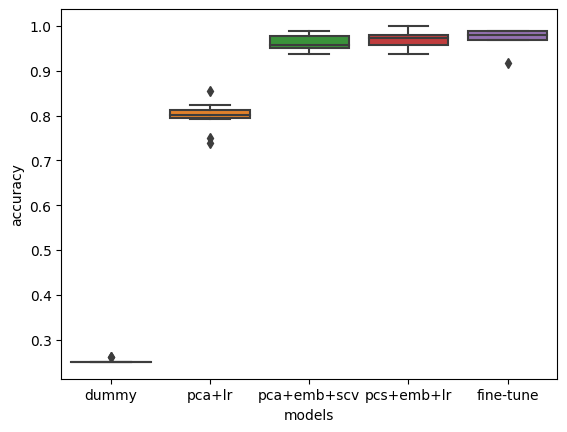

In [ ]:
sns.boxplot(data=df_result, x="models", y="accuracy")

### Training Time

In [ ]:
221*221*3

146523

<Axes: xlabel='models', ylabel='fit_time(s)'>

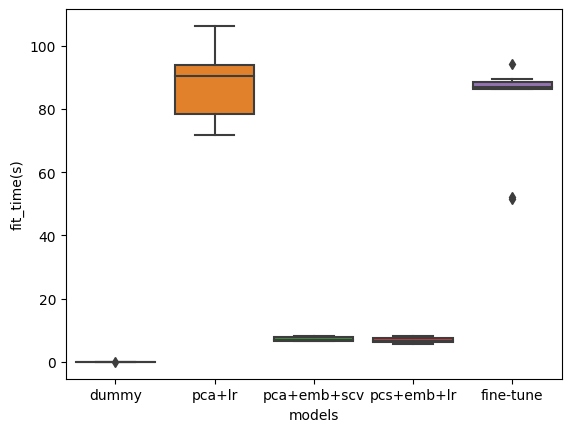

In [ ]:
sns.boxplot(data=df_result, x="models", y="fit_time(s)")

### Scoring Time

<Axes: xlabel='models', ylabel='score_time(s)'>

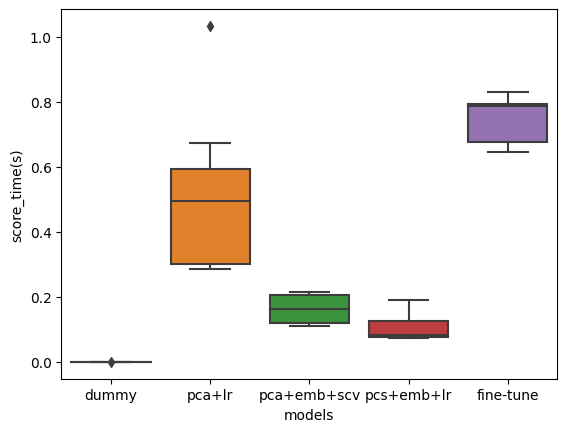

In [ ]:
sns.boxplot(data=df_result, x="models", y="score_time(s)")

#### Performance Final Melhor Modelo

In [ ]:
pipe_embeddings_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=.95)),
    ('lr', LogisticRegression(random_state=42))
])

clf_embeddings_lr = pipe_embeddings_lr.fit(X_train_embeddings, y_train)
y_pred_clf_embeddings_lr = clf_embeddings_lr.predict(X_test_embeddings)

report = classification_report(y_test, y_pred_clf_embeddings_lr, target_names=labels_name)
print(report)

                   precision    recall  f1-score   support

         not_face       0.97      0.97      0.97        62
partially_covered       1.00      1.00      1.00        60
      not_covered       0.98      0.98      0.98        60
    fully_covered       0.95      0.95      0.95        58

         accuracy                           0.97       240
        macro avg       0.97      0.97      0.97       240
     weighted avg       0.97      0.97      0.97       240



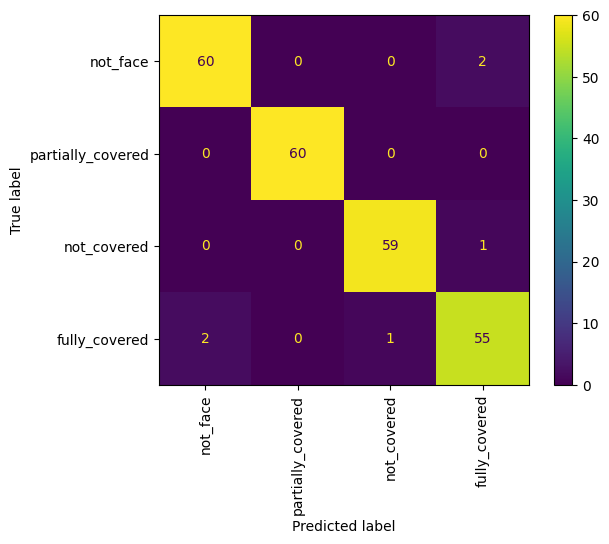

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels = [labels_name[i] for i in y_test]

cm = confusion_matrix(y_test, y_pred_clf_embeddings_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_name)
disp.plot()
plt.xticks(rotation=90)
plt.show()

### Definição de politica de Uso do Modelo

* Caso 1: Risco Máximo (RM)
  * 100 pontos se 'not_covered'
  * 75 pontos se 'partially covered'
  * 25 pontos se 'fully_covered'
  * 0 pontos se 'not_face'


Podemos equacionar o problema da seguinte forma:

  $$ RM = \frac{1}{n-\alpha }\sum_{i=0}^{n} w_i$$

  * $w_i:$ pontos associado a classe mais provavel exemplo $i$
  * $n:$ numero de faces encontradas
  * $\alpha:$ numero de 'not_face'

In [ ]:
y_pred_proba = clf_embeddings_lr.predict_proba(X_test_embeddings)
y_pred = clf_embeddings_lr.predict(X_test_embeddings)

classes_ponto = classes.copy()
classes_ponto["not_covered"] = 100
classes_ponto["partially"] = 75
classes_ponto["fully_covered"] = 25
classes_ponto["not_face"] = 0

wi = [classes_ponto[classes_[i]] for i in y_pred_prob.argmax(axis=-1)]
alpha = np.sum(y_pred == 0)
n = len(y_pred)

RM = np.sum(wi) / (n-alpha)
RM

41.06741573033708

## **7. Deployment**

### Salvando modelo

In [ ]:
import pickle

#salvar embbeding
embedding_filename = "embeding_features.keras"
feature_extractor.save(embedding_filename)

# salvar modelo
model_filename = "final_model.pkl"
pickle.dump(clf_embeddings_lr, open(model_filename, 'wb'))

### Carregando Pipeline de Predição

In [ ]:
import keras
from PIL import Image


def read_image_from_dir_(
    directory,
    image_size,
    color_mode="RGB",
):

  class_dir = os.path.join(directory)
  images_dirs = [
      os.path.join(class_dir, f)
      for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))
  ]

  X = []
  for i in images_dirs:
    img = Image.open(i)
    img = img.convert('L')
    img = img.convert(color_mode)
    img = img.resize(image_size)

    X.append(np.asarray(img))

  return np.array(X)

def predict(directory):
  # carregar images
  image_size = (224, 224)
  X = read_image_from_dir_(directory, image_size)

  # carregar embeding
  embedding_filename = "embeding_features.keras"
  feature_extractor = keras.models.load_model('embeding_features.keras')
  X_embedding = feature_extractor.predict(X)

  # carregar modelo
  model_filename = "final_model.pkl"
  model = pickle.load(open(model_filename, 'rb'))

  return model.predict_proba(X_embedding)

def rm_score(y_pred_prob):
  class_ = {0: 'not_face', 1: 'partially_covered', 2: 'not_covered', 3: 'fully_covered'}
  classes_ponto = {}
  classes_ponto["not_covered"] = 100
  classes_ponto["partially_covered"] = 75
  classes_ponto["fully_covered"] = 25
  classes_ponto["not_face"] = 0

  wi = [classes_ponto[classes_[i]] for i in y_pred_prob.argmax(axis=-1)]
  alpha = np.sum(y_pred_prob == 0)
  n = len(y_pred_prob)

  return np.sum(wi) / (n-alpha)


In [ ]:
directory = "mask_dataset/partially_covered"
predictions = predict(directory)
predictions

13/13 [==============================] - 2s 171ms/step


array([[1.50209127e-10, 9.99999937e-01, 3.20671093e-11, 6.26588093e-08],
       [8.85266714e-05, 9.76473254e-01, 8.40942644e-07, 2.34373784e-02],
       [6.68094577e-08, 9.96213104e-01, 2.04281149e-06, 3.78478633e-03],
       ...,
       [1.32500255e-07, 9.97281519e-01, 4.21592281e-08, 2.71830672e-03],
       [5.21507489e-08, 9.99927735e-01, 4.42781149e-08, 7.21683505e-05],
       [3.46073637e-11, 9.99698991e-01, 1.96080680e-11, 3.01009247e-04]])

In [ ]:
rm = rm_score(predictions)
print("Risco Maximo: ", round(rm))

Risco Maximo:  71


In [ ]:
np.unique(predictions.argmax(axis=-1), return_counts=True)

(array([0, 1, 2, 3]), array([  6, 360,   1,  25]))

In [ ]:
classes_

{0: 'not_face', 1: 'partially_covered', 2: 'not_covered', 3: 'fully_covered'}

#### Testando em uma amostra

In [ ]:
directory = "image_output/"
predictions = predict(directory)
predictions.argmax(axis=-1)

1/1 [==============================] - 0s 159ms/step


array([2, 3, 2, 3, 3, 2, 2, 0, 1, 1, 0, 2, 2, 0, 2, 3, 3, 0, 0, 0, 1, 2,
       2, 1])

In [ ]:
rm = rm_score(predictions)
print("Risco Maximo: ", round(rm))

Risco Maximo:  55


### Use o modelo com uma foto sua

1. Tire uma foto do seu rosto usando mascara de proteção
2. Crie um diretório chamado `my-photo`
3. Faça upload da foto no diretorio `my-photo`
4. Execute o comando abaixo que chama a função `predict`
5. Verifique se o modelo fez predição corretamente
6. Repita os passos com outras fotos =D


In [ ]:
directory = "my-photo"
predictions = predict(directory)
classes_[predictions.argmax(axis=-1)[0]]

1/1 [==============================] - 0s 158ms/step


'not_face'

## **8. Beyond Deployment: O que vem depois e não te contaram**

### Governança de Modelos

#### O que é?

A governança do modelo é o processo geral de como uma organização controla o acesso, implementa políticas e rastreia atividades de modelos e seus resultados.

#### Por que é importante?

* Torna modelos auditaveis
* Controla risco
* Cria ações de controle

#### O que fazer?
* Documentação do modelo
  * dados usados
  * hyperparâmetros
* Checar boas práticas
* Estratégias para controlar modelo em produção
* Estratégias para versionar modelo
* Estratégia de monitoramento e ações
* Planos de ação para riscos


![gov](https://ml-ops.org/img/metadata-mngt.png)

### Model Monitoring

#### O que é?

O monitoramento de modelo refere-se ao processo de acompanhar de perto o desempenho dos modelos de aprendizado de máquina em produção. Ele permite a identificação e eliminação de problemas ao longo da vida do modelo, incluindo previsões de baixa performance e mudança de comportamento nos dados.

#### Por que é importante?

* Dados podem mudar ao passar do tempo
* Fontes de dados podem quebrar, deixar de existir
* A performance do modelo pode degradar com mudanças não controladas

#### O que fazer?

* Monitorar mudança nas distribuilções features mais importantes para modelo
* Monitorar performance ao longo to tempo
* Monitorar metricas de negócio (KPIs)
* Monitorar integridade das fontes de dados

![data](https://newrelic.com/sites/default/files/styles/1200w/public/2021-12/model-performance-monitoring.png?itok=CvQuxw2S)

### Retraining

#### O que é?

Retreino sistemático do modelo com dados novos.

#### Por que é importante?

* Dados podem mudar ao passar do tempo
* Performance pode degradar

#### O que fazer?

* Retreinar modelo com novos dados
* Em geral é necessário re-ajustar hyperparametros
* Retreino pode ser indicado quando a performance degrada k% (k deve ser decidido pelo negócio)
* Retreino pode ser automático e periódico (usar dados passados para descobrir periodicidade)

![a](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTzTSzeWRwBdAdM7pXlsSU2MAS0203YkFdpKA&usqp=CAU)